# Imports

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer

# Load Data

In [202]:
df = pd.read_csv('../Data/sub_reddit_data.csv')
df.head(1)

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,num_crossposts,media,is_video,retrieved_utc,updated_utc,utc_datetime_str,post_hint,preview,link_flair_template_id,author_cakeday
0,AskWomen,[removed],t2_v4u69ho5,0,How about true friendship between men and wome...,[],r/AskWomen,False,6,NaN,...,0,NaN,False,1682375081,1682375081,2023-04-24 22:24:26,NaN,NaN,NaN,NaN


# Clean and select features

This portion is where we will select our inital features. As we clean our data we will continue to add additional features.

The inital features we selected were
1) Subreddit name
2) Title of the post
3) If the post has been hidden
4) The time Stamp
5) The number of comments

In [203]:
df.columns.sort_values()

Index(['all_awardings', 'allow_live_comments', 'archived', 'author',
       'author_cakeday', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext',
       'author_flair_template_id', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'author_fullname',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_gild',
       'category', 'content_categories', 'contest_mode', 'created_utc',
       'discussion_type', 'distinguished', 'domain', 'edited', 'gilded',
       'gildings', 'hidden', 'hide_score', 'id', 'is_created_from_ads_ui',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media',
       'media_embed', 'media_only', 'no_follow

In [204]:
clean_df=df[['id', 'subreddit','title','hidden','utc_datetime_str', 'num_comments']]

In [205]:
clean_df.head(3)

,id,subreddit,title,hidden,utc_datetime_str,num_comments
0,12xyt9k,AskWomen,How about true friendship between men and wome...,False,2023-04-24 22:24:26,0
1,12xymt1,AskWomen,Does this mean she’s not interested? What shou...,False,2023-04-24 22:18:10,1
2,12xylur,AskWomen,What’s something that your brain cannot compre...,False,2023-04-24 22:17:10,0


## Feature engineering

### Creating a date column
This portion is used to get the date of a post, and identify what day of the week of a post

In [206]:
#convert the utc_datetime_str into a date time data type
clean_df['utc_datetime_str']= pd.to_datetime(clean_df['utc_datetime_str'])

C:\Users\Derik\AppData\Local\Temp\ipykernel_9872\1929073113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['utc_datetime_str']= pd.to_datetime(clean_df['utc_datetime_str'])


In [207]:
clean_df.dtypes

id                          object
subreddit                   object
title                       object
hidden                        bool
utc_datetime_str    datetime64[ns]
num_comments                 int64
dtype: object

In [208]:
#referenced this stack overflow: https://stackoverflow.com/questions/28009370/get-weekday-day-of-week-for-datetime-column-of-dataframe
clean_df['day_name'] = clean_df['utc_datetime_str'].apply(lambda x: x.day_name())

C:\Users\Derik\AppData\Local\Temp\ipykernel_9872\1765243622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['day_name'] = clean_df['utc_datetime_str'].apply(lambda x: x.day_name())


In [209]:
clean_df.head(3)

,id,subreddit,title,hidden,utc_datetime_str,num_comments,day_name
0,12xyt9k,AskWomen,How about true friendship between men and wome...,False,2023-04-24 22:24:26,0,Monday
1,12xymt1,AskWomen,Does this mean she’s not interested? What shou...,False,2023-04-24 22:18:10,1,Monday
2,12xylur,AskWomen,What’s something that your brain cannot compre...,False,2023-04-24 22:17:10,0,Monday


### Creating a title word count column
This portion is used to check the word count of a title

In [210]:
clean_df['title_word_count'] = clean_df['title'].apply(lambda text: len(text.split()))

C:\Users\Derik\AppData\Local\Temp\ipykernel_9872\1392333841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['title_word_count'] = clean_df['title'].apply(lambda text: len(text.split()))


In [211]:
#see distribution of word counts
clean_df['title_word_count'].value_counts(sort=True)

9     333
8     325
10    312
12    290
11    269
7     252
13    213
6     206
14    205
15    198
17    153
16    150
18    123
5     108
19    100
20     76
4      74
21     58
23     57
3      51
22     50
2      47
1      42
24     40
25     39
26     27
27     25
31     20
28     19
29     14
30     13
32     11
35      9
34      7
49      6
36      6
39      5
33      5
52      5
37      4
44      4
42      3
38      3
47      3
56      3
41      3
59      3
54      3
43      3
53      2
51      2
40      2
45      2
50      2
46      2
48      1
62      1
58      1
63      1
60      1
Name: title_word_count, dtype: int64

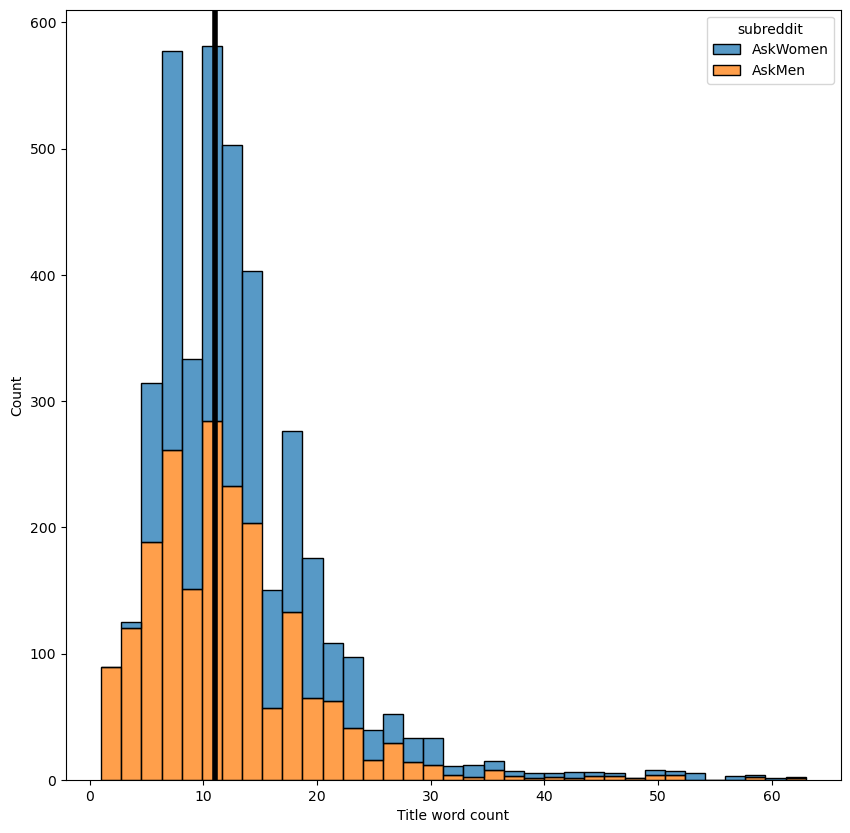

In [212]:
plt.figure(figsize=(10,10))
sns.histplot(data= clean_df, multiple ="stack", x = 'title_word_count', hue='subreddit', bins=35)
plt.axvline(x=clean_df['title_word_count'].median(), color='black', linewidth=4)
plt.xlabel("Title word count");

It appears there are vastly more post in askwomen and the median words in titles 

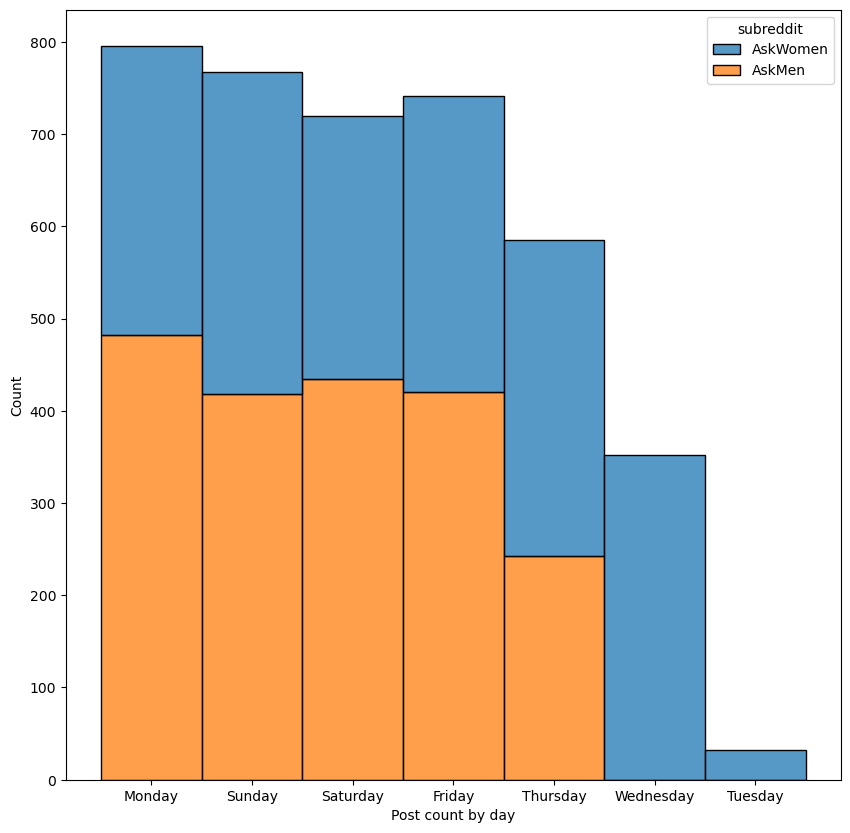

In [213]:
#Overview of post frequencies by day
plt.figure(figsize=(10,10))
sns.histplot(data= clean_df, multiple ="stack", x = 'day_name', hue='subreddit')
plt.xlabel("Post count by day");

It appears the frequency of post is significantly higher in AskWomen that it is in askmen. The days with the fewest post are from wednesday and tuesday.

### Checking the 'hidden' column
This portion is to check to see if a post has been hidden

In [214]:
#check the hidden column
clean_df['hidden'].value_counts()

False    3992
Name: hidden, dtype: int64

In [215]:
#removed the hidden column since there are only false values
clean_df.drop(columns = 'hidden', inplace=True)

C:\Users\Derik\AppData\Local\Temp\ipykernel_9872\1289743119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.drop(columns = 'hidden', inplace=True)


### Checking the num_comments column
This portion is used to check how many comments are in each post.

In [216]:
'''
I had assumed num_comments was the number of comments within a thread, but thought the valuecounts was weird,
so when I looked at the api documentation it didnt specific what it was.
The Api documentation just states that num_comments is an integer between 1 and 500.

Will need to see how many post have been removed as well because that indicates a post was removed before
people could respond.
'''
clean_df['num_comments'].value_counts()

1    2300
0    1691
3       1
Name: num_comments, dtype: int64

________________________________________________________________________________
### Checking the removed column
This portion is used to check if a significant number of our post were removed

In [217]:
#check percent of post removed, df is the entire dataset without filtering
df['removed_by_category'].value_counts() / len(df)

moderator           0.666333
automod_filtered    0.047595
deleted             0.018537
reddit              0.015030
Name: removed_by_category, dtype: float64

Here is appears about 70% of post have been removed. I will now create a feature for our dataframe to determine if a post has bee removed.

In [218]:
#check to see first few, here we see a nan, so we assume its not removed
df['removed_by_category'].head(5)

0    automod_filtered
1           moderator
2                 NaN
3           moderator
4           moderator
Name: removed_by_category, dtype: object

In [219]:
#check to see if the true/false match
df['removed_by_category'].notnull().head(5).astype(int)

0    1
1    1
2    0
3    1
4    1
Name: removed_by_category, dtype: int32

In [220]:
#NaNs indicate that a post was not removed,
clean_df['is_removed'] = df['removed_by_category'].notnull().astype(int)

C:\Users\Derik\AppData\Local\Temp\ipykernel_9872\3374793744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['is_removed'] = df['removed_by_category'].notnull().astype(int)


In [221]:
clean_df['is_removed'].value_counts(normalize=True)

1    0.747495
0    0.252505
Name: is_removed, dtype: float64

Close to 75% of our data has been removed. Which is intresting. I wonder what type of questions get removed and which subreddit is more "heavily" moderated. With a high numer of removed post, it makes sense for the low number of comments, but it still feels low.

In [222]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3992 entries, 0 to 3991
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                3992 non-null   object        
 1   subreddit         3992 non-null   object        
 2   title             3992 non-null   object        
 3   utc_datetime_str  3992 non-null   datetime64[ns]
 4   num_comments      3992 non-null   int64         
 5   day_name          3992 non-null   object        
 6   title_word_count  3992 non-null   int64         
 7   is_removed        3992 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(2), object(4)
memory usage: 234.0+ KB


## Visualizing metrics

# Export cleaned data to a CSV

In [223]:
#set an index, so when we model id is not a variable
clean_df.set_index('id', inplace=True)

In [224]:
clean_df.to_csv('../Data/sub_reddit_data_clean.csv')

# Vectorizing title data

In [228]:
#loading in data, so we dont have to run the entire notebook again
vect_df = pd.read_csv('../Data/sub_reddit_data_clean.csv')

In [260]:
cvec = CountVectorizer(stop_words='english')
X= vect_df['title']
X_cv = cvec.fit_transform(X)
X_cv.shape

(3992, 4600)

In [261]:
words_df = pd.DataFrame(X_cv.todense(), columns=cvec.get_feature_names_out())
words_df.head()

,0ft,10,100,1000,10k,11,12,120,13,15,...,youve,yr,yrs,zaralynn,zodiac,zone,вопросы,задавайте,миллионеров,сын
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [277]:
women_word = words_df[vect_df['subreddit'] == 'AskWomen'].sum().sort_values(ascending=False)

In [276]:
men_word = words_df[vect_df['subreddit'] == 'AskMen'].sum().sort_values(ascending=False)

_______________________________________________________

In [302]:
women_word.head(25)

women           314
did             155
men             120
feel            118
partner         116
like            112
man             109
does            101
relationship     98
guy              95
think            85
ladies           84
know             68
life             65
woman            65
want             64
love             63
date             58
best             57
make             55
just             53
friends          50
sex              48
girl             48
dating           48
dtype: int64

Text(0.5, 1.0, 'Top 25 words in AskWomen')

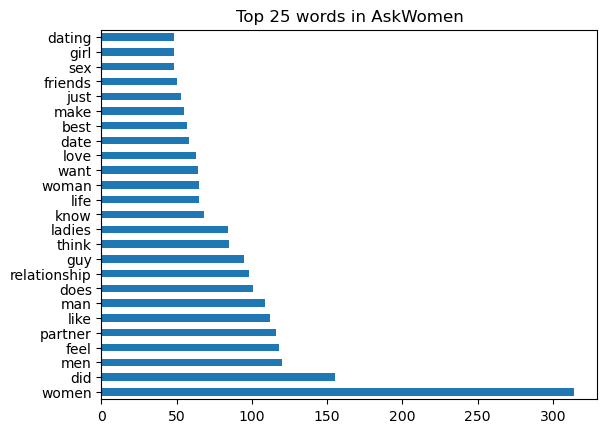

In [281]:
women_word.head(25).plot(kind ='barh')
plt.title('Top 25 words in AskWomen')

In [301]:
men_word.head(25)

men             361
women           116
woman           115
guys            106
did             106
like             99
girl             84
relationship     82
man              74
think            73
guy              70
feel             70
does             67
partner          62
just             62
friend           58
reddit           56
dating           54
sex              52
life             51
make             50
want             48
love             48
advice           47
girlfriend       46
dtype: int64

Text(0.5, 1.0, 'Top 25 words in Askmen')

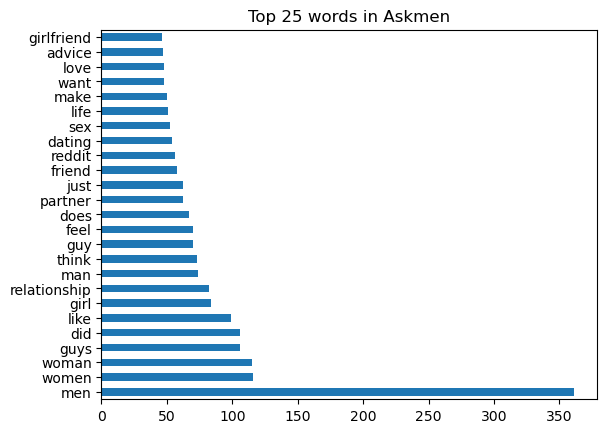

In [282]:
men_word.head(25).plot(kind ='barh')
plt.title('Top 25 words in Askmen')

<AxesSubplot:>

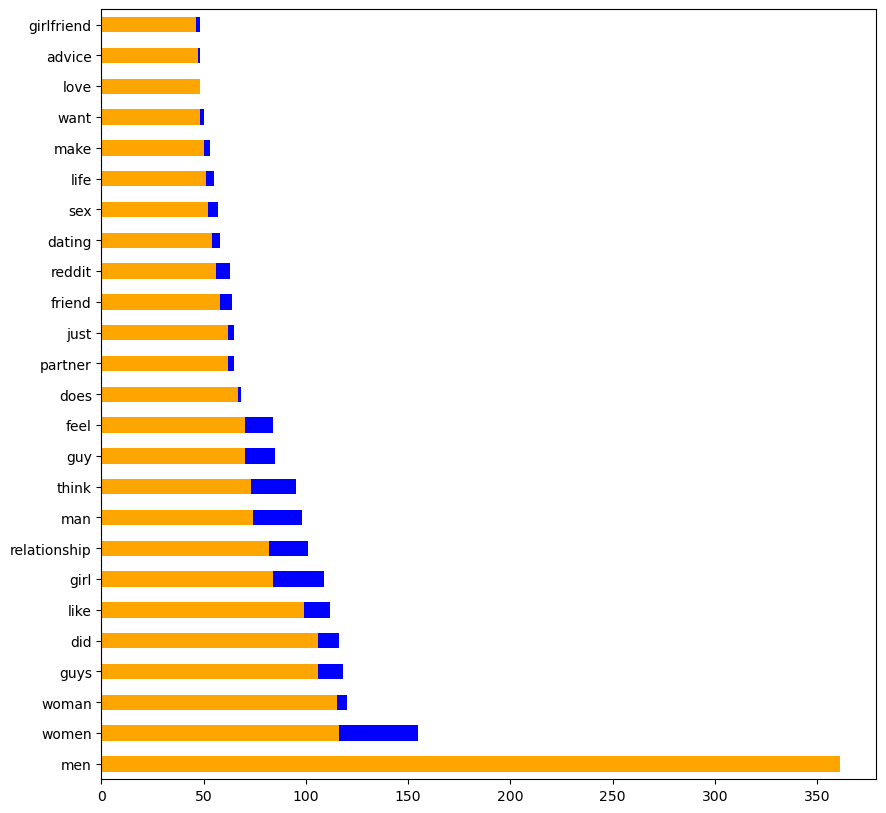

In [298]:
plt.figure(figsize=(10,10))
women_word.head(25).plot(kind ='barh', color = 'blue', label = 'Women')
men_word.head(25).plot(kind ='barh', color = 'orange', label = 'Men')

<BarContainer object of 25 artists>

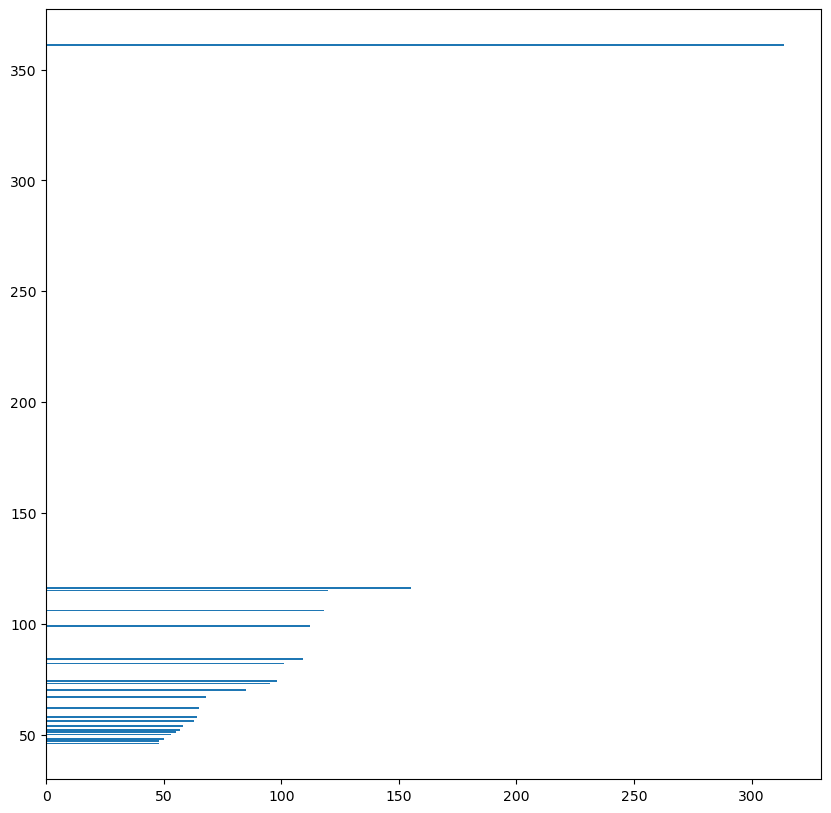

In [284]:
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(men_word.head(25))